In [1]:
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
import matplotlib as mpl
%matplotlib inline
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')

In [2]:
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)

In [3]:
mat = np.array(df)
per_cell_sum = mat.sum(axis=1)
per_gene_sum = mat.sum(axis=0)
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
mat = mat[:, CV >= 1.5]
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
#df = pd.DataFrame(mat,index=mat[:,0])

In [4]:
def dendrogrammer(df, leaf_labels):
    D = df.values
    if len(leaf_labels) != len(D):
        D = np.transpose(D)
    Z = linkage(D, method='ward', metric='euclidean')
    plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom = 0.3, right = 0.98, top = 0.95, wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    
    dendrogram(Z, leaf_rotation=90., leaf_font_size=10., labels = leaf_labels)
    plt.savefig('DATASET2: DENDROGRAM.png')

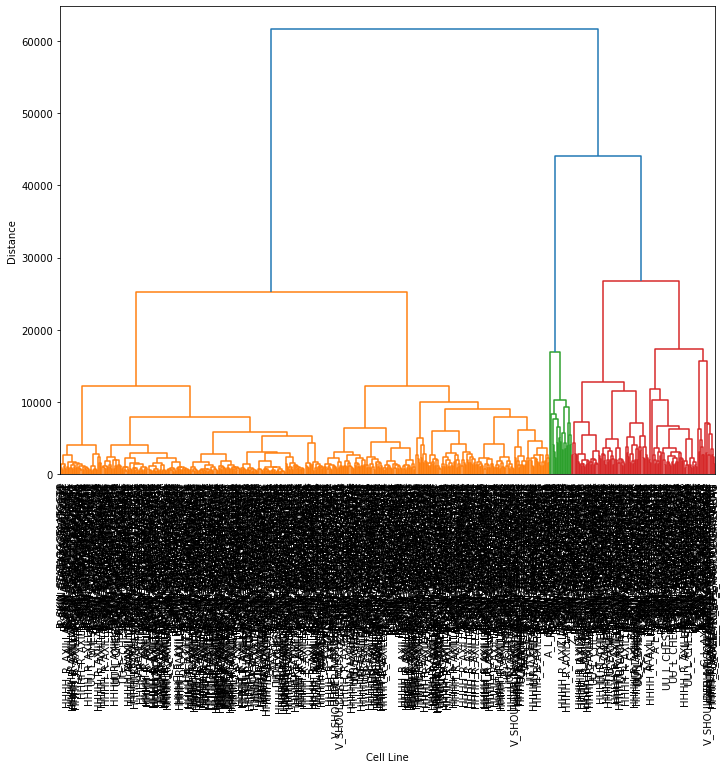

In [5]:

dendrogrammer(df, cells)

In [6]:
def PCAer(df):
     print(df.values)
     D = df.values
     D = np.transpose(D)
     pca = PCA(n_components= 50)
     pca.fit(D)
     projected = pca.fit_transform(D)
     return projected

In [7]:
from sklearn.cluster import KMeans
Dpc = PCAer(df)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(Dpc)
labels = kmeans.predict(Dpc)
C = kmeans.cluster_centers_
out = [Dpc, labels, C]
[proj, labels, centroids] = out
true_coords = {}
true_cells = {}
true_labels = {}
for i in range(len(Dpc)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i:i+1,1]) + " " + str(proj[ i:i+1,2])
    true_cells.update({str(coords).strip():labels[i]})
    true_labels.update({cells[i]:labels[i]})
    true_coords.update({cells[i]:str(coords).strip()})
'''
def kmeanser(df, k): 
    Dpc = PCAer(df)
    kmeans = KMeans(n_clusters=3)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    C = kmeans.cluster_centers_
    out = [Dpc, labels, C]
    print(np.bincount(kmeans.labels_))
    return out
'''
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [159 215 200 ... 176 185   0]
 [  0   3   2 ...   2   2   0]
 [377 722 855 ... 525 151   1]]


In [8]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = true_labels
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    trueCount = 0
    for i in truthnum1:
        if(truthnum1[i] == 'black'):
            trueCount += 1
    trueCount /= 626
    trueCount *= 100
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    print(len(truthnum1))
    return truthnum1, trueCount


In [9]:
def DataCollectionP(algorithm, cluster_1, cluster_2, cluster_3, results):  
    labels = true_labels
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    truthnum2 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#6E316F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'#FCC7FD'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'G2M'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#F204F9'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#003674'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#EBF3FA'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G2M'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#4BABFF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#006506'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#E6F9E5'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G2M'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FF0F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    return truthnum1, truthnum2

626


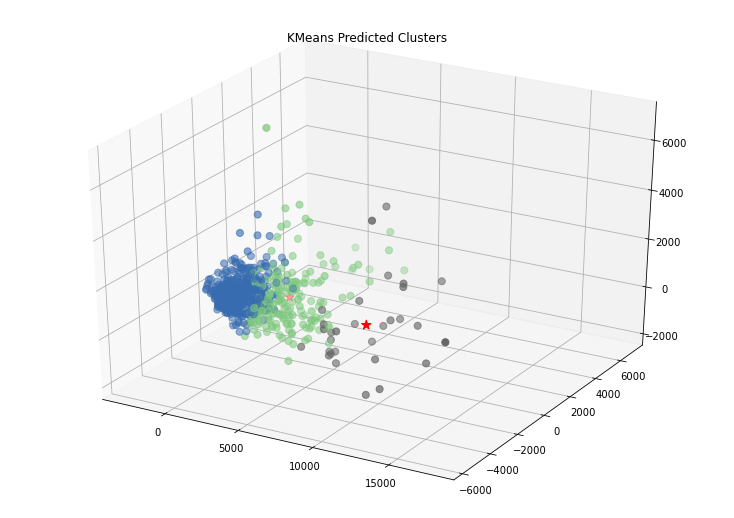

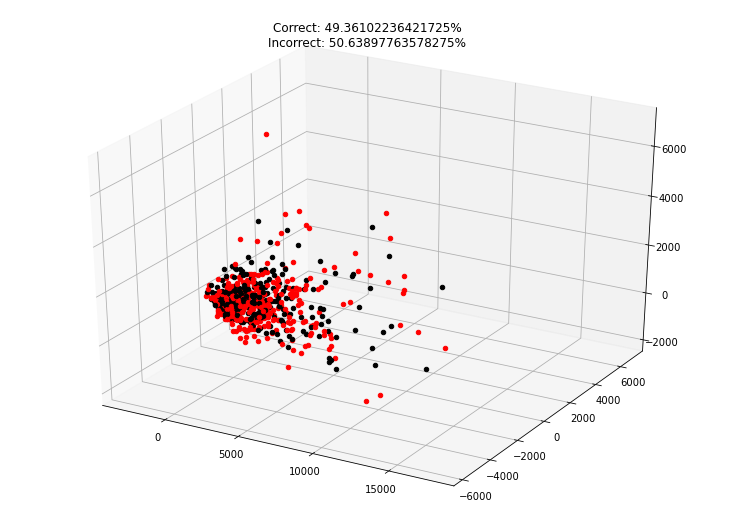

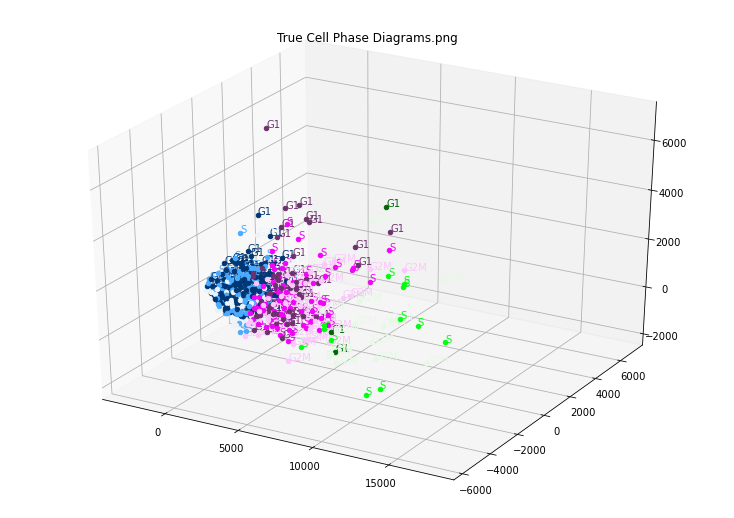

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1 = Axes3D(fig1)
[proj, labels, centroids] = out
ax1.scatter(proj[:,0], proj[:, 1], proj[:, 2], c=labels, s=50, cmap='Accent')

colors, trueNum = DataCollection(kmeans, 'kmeans_cluster1.txt', 'kmeans_cluster2.txt', 'kmeans_cluster3.txt', 'kmeans_results.txt')
colorsP, truthnum2 = DataCollectionP(kmeans, 'kmeans_cluster1P.txt', 'kmeans_cluster2P.txt', 'kmeans_cluster3P.txt', 'kmeans_resultsP.txt')
ax1.scatter(centroids[:,0], centroids[:, 1], centroids[:,2], c = 'red', s=100, marker='*', cmap='Accent')
ax1.set_title("KMeans Predicted Clusters")
plt.savefig("DATASET2: KMEANS PREDICTION.png")

fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111)
ax2 = Axes3D(fig2)
ax2.set_title("\nCorrect: " + str(trueNum) + "%" + "\nIncorrect: " + str(100-trueNum) + "%")
for i in range(len(proj)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i:i+1,1]) + " " + str(proj[ i:i+1,2])
    ax2.scatter(proj[i:i+1, 0], proj[i:i+1, 1], proj[i:i+1, 2], c=colors[coords])
plt.savefig("DATASET2: KMEANS TVP.png")
fig3 = plt.figure(figsize=(10, 7))
ax3 = fig3.add_subplot(111)
ax3 = Axes3D(fig3)
for i in range(len(proj)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i:i+1,1]) + " " + str(proj[i:i+1,2])
    ax3.scatter(proj[i:i+1, 0], proj[i:i+1, 1], proj[i:i+1, 2], c=colorsP[coords])
    x = np.int(proj[i:i+1, 0])
    y = np.int(proj[i:i+1,1])
    z = np.int(proj[i:i+1,2])
    label = truthnum2[coords]
    ax3.text(x, y, z, label, size=10, color=colorsP[coords])
ax3.set_title("True Cell Phase Diagrams.png")
plt.savefig("DATASET2: KMEANS TRUE CELL PHASE.png")

In [ ]:
plt.scatter(proj[:,0], proj[:,2], s=10.0, color='black')
plt.scatter(centroids[:,0], centroids[:, 2], c = 'red', s = 100, marker='*', cmap='Accent')

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [159 215 200 ... 176 185   0]
 [  0   3   2 ...   2   2   0]
 [377 722 855 ... 525 151   1]]


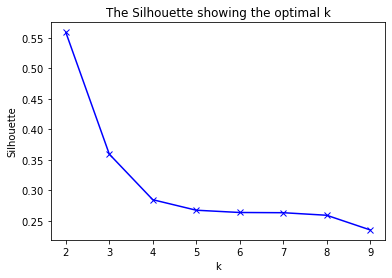

In [16]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
sil = []
Dpc = PCAer(df)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    sil.append(silhouette_score(Dpc, labels))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('The Silhouette showing the optimal k')
plt.savefig('DATASET2: SILHOUETTE PLOT.png')

In [17]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    #distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis = 1))/df.shape[0])
    distortions.append(kmeanModel.inertia_)
print(distortions)

[12270207289.95716, 5016582030.586239, 3359126464.39645, 2225696527.529981, 1776159684.0851116, 1500499909.8919804, 1273079851.3802006, 1062041564.7802004, 949170267.7330276]


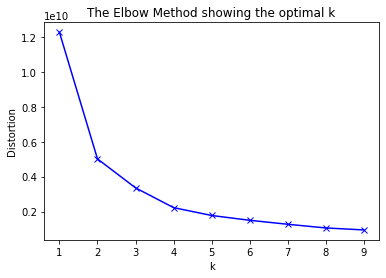

In [18]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('DATASET2: ELBOW PLOT.png')